# Tropical Pet Fish Disease Diagnosis ML Project

## Description
Many new hobbyists struggle with identifying and treating disease in their fish and can cause them to quit the hobby prematurely. 

The goal of this project is to provide assistance to new aquarium hobbyists with diagnosis of common diseases in tropical freshwater fish by using external and behavioral symptoms to lead to a diagnosis using multi-class classification models and attempt to help them understand why their fish may be ill. 

The dataset was collected manually from several websites, diseases that were listed on the website were converted to examples by making each symptom a one-hot variable (information used to make a prediction) and making the target variable (what we want to predict) the name of the disease.

__Disclaimer__: in most cases accurate diagnosis and treatment of a disease can only be done by a professional veterinarian with their experience, education, and access to diagnostic equipment such as a high-power microscope. 

The general consensus within the fish-keeping community is that the best way to treat a disease is to avoid it in the first place through preventative measures such as inspecting fish before purchasing, quarantining, regular water changes, and ensuring the water parameters (pH, temperature, GH, KH, nitrate, nitrite, ammonia, oxygen levels) and stocking density are within the comfort zone of the fish that are being kept.

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    make_scorer,
    #plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

## Exploratory Data Analysis


In [4]:
df = pd.read_csv("tropicalfishdiseasedata.csv", encoding="utf-8")
df.head()

,disease,source,pits_on_head_lateral_line,stringy_feces,white_feces,difficulty_swimming,erratic_swimming,bulging_eyes,cloudy_eyes,weight_loss,...,mouth_lesions,white_spots,yellow_spots,mucous_skin,velvety_skin,visible_parasite,protruding_scales,bloated_abdomen,clamped_fins,ragged_fins
0,low_oxygen,Disorders and Diseases of Fish - All Other Pet...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,flukes,Disorders and Diseases of Fish - All Other Pet...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,columnaris,Disorders and Diseases of Fish - All Other Pet...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,ich,Disorders and Diseases of Fish - All Other Pet...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,velvet,Disorders and Diseases of Fish - All Other Pet...,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [5]:
df.shape

(58, 36)

The dataset consists of 58 examples and 36 columns, 34 columns represent each external or behavioural symptom of a disease (features), the variable is 1 if the symptom exists in a fish and 0 if not. The second column provides the source for the disease descriptions from which the symptoms for each disease were taken. The first column is the target column which is the name of the disease.

In [2]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   disease                    58 non-null     object
 1   source                     58 non-null     object
 2   pits_on_head_lateral_line  58 non-null     int64 
 3   stringy_feces              58 non-null     int64 
 4   white_feces                58 non-null     int64 
 5   difficulty_swimming        58 non-null     int64 
 6   erratic_swimming           58 non-null     int64 
 7   bulging_eyes               58 non-null     int64 
 8   cloudy_eyes                58 non-null     int64 
 9   weight_loss                58 non-null     int64 
 10  deformed                   58 non-null     int64 
 11  discolored                 58 non-null     int64 
 12  lost_appetite              58 non-null     int64 
 13  lethargy                   58 non-null     int64 
 14  cant_stay_up

The name of every column can be seen above. It appears that there are no missing values.

In [8]:
df[["disease"]].value_counts()

disease               
anchor_worm               5
ich                       5
fin_rot                   5
velvet                    4
mycobacteria              4
hemorrhagic_septicemia    4
flukes                    4
hexamita                  3
aeromonas                 3
fish_lice                 3
dropsy                    3
constipation              3
columnaris                3
fungal_infection          3
low_oxygen                2
lymphocystis              2
swim_bladder_disease      2
Name: count, dtype: int64

In [9]:
df[["disease"]].value_counts().shape

(17,)

There are 17 different diseases, these were considered the most common diseases encountered in the aquarium hobby and do not represent all possible diseases. As this dataset was collected by hand, there are a few diseases which are underrepresented (low_oxygen, lymphocystis, swim_bladder_disease) and overall there may not be enough examples for accurate classification. 

### Potential Issues with the Data

1. Only 17 diseases which were considered common were included.
2. The symptoms used as features were created manually and symptoms with similar wording were grouped together by the data collector's discretion (e.g. bloating and enlarged abdomen).
3. Symptom descriptions for diseases varied wildly between sources, some descriptions may be missing symptoms or include incorrect symptoms.
4. The dataset is rather small which makes cross-validation difficult.
5. There are many symptoms which can cause overfitting.

## Model Assessment

First, split the data into train and test portions using sklearn's train_test_split method.

In [10]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

X_train = train_df.drop(columns=["disease", "source"])
y_train = train_df["disease"]

X_test = test_df.drop(columns=["disease", "source"])
y_test = test_df["disease"]

Train and score a baseline model. In this case, we use sklearn's DummyClassifier with the strategy of most-frequent. The scoring criteria is accuracy.

In [11]:
dc = DummyClassifier(strategy="most_frequent")

dc.fit(X_train, y_train)

print(dc.score(X_train, y_train))

0.1


The baseline model's accuracy is 0.1.

### Logistic Regression

In [12]:
lr = LogisticRegression(max_iter = 300)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6111111111111112

This code is creating, training, and evaluating a `LogisticRegression` model from the `sklearn.linear_model` module.

Here's a breakdown of the code:

1. `lr = LogisticRegression(max_iter = 300)`: This line creates a `LogisticRegression` model with the maximum number of iterations set to 300. This means that the algorithm will iterate up to 300 times to find the best parameters for the model. If the model converges (i.e., finds the best parameters) before reaching 300 iterations, it will stop early.

2. `lr.fit(X_train, y_train)`: This line trains the `LogisticRegression` model on the training data. `X_train` is the training data (the features), and `y_train` is the training labels (the classes). The model learns to predict the labels based on the features.

3. `lr.score(X_test, y_test)`: This line evaluates the `LogisticRegression` model on the testing data and returns the accuracy score. The accuracy score is the proportion of correct predictions: the number of correct predictions divided by the total number of predictions. `X_test` is the testing data (the features), and `y_test` is the testing labels (the classes). The model uses the features to make predictions, and then compares these predictions to the actual labels to calculate the accuracy score.

The accuracy of the model with default hyperparameters was 0.61. Ideally I would have used cross-validation before assessing the model on the test data, however the number of examples per class is too small to have splits that are good representations of the overall dataset.

Tuning Hyperparameter C

Best accuracy was  0.7777777777777778  with C value =  3.1622776601683795


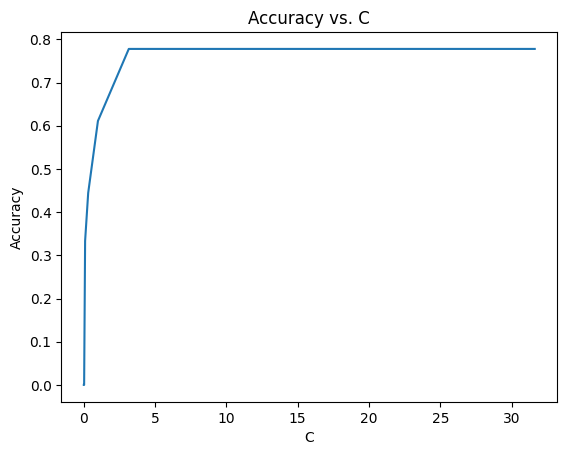

In [13]:
C_vals = 10.0 ** np.arange(-2, 2, 0.5)

score_best = 0
C_best = 0

scores = []

for c in C_vals:
    lr = LogisticRegression(max_iter=300, C = c)
    lr.fit(X_train, y_train)
    s = lr.score(X_test, y_test)
    scores.append(s)
    if (s > score_best):
        score_best = s
        C_best = c

plt.plot(C_vals, scores)
plt.title("Accuracy vs. C")
plt.xlabel("C")
plt.ylabel("Accuracy")
        
print("Best accuracy was ", score_best, " with C value = ", C_best) 

After tuning the hyperparameter C, it was found that the best accuracy 0.78 was given by a C value of 3.16.

A nice feature of logistic regression is that it provides an easy way to extract probabilities for each disease. Here I use a single example with true class of 'velvet' to demonstrate this using a bar graph.

In [14]:
ex = X_train.iloc[[0]]
ex.columns[      
    (ex == 1)        # mask 
    .any(axis=0)     # mask
]

Index(['weight_loss', 'difficulty_breathing', 'scratching', 'yellow_spots',
       'velvety_skin'],
      dtype='object')

(0.0, 1.0)

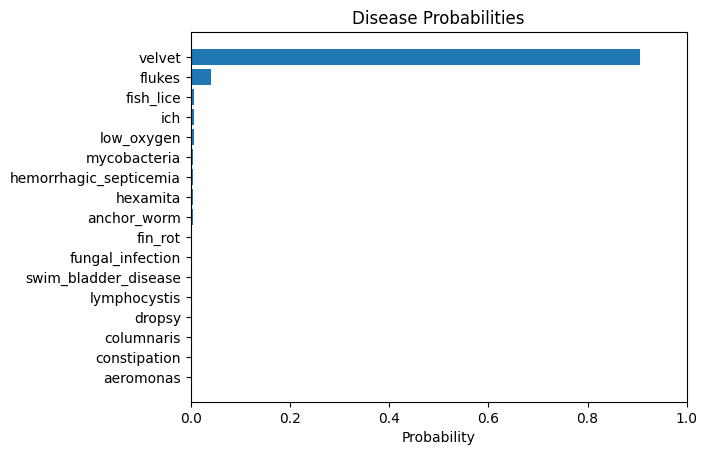

In [15]:
lr = LogisticRegression(max_iter = 300, C = 3.16)

lr.fit(X_train, y_train)

p = lr.predict_proba(ex)[0]

diseases = lr.classes_

df2 = pd.DataFrame([diseases,p]).T.sort_values(1,ascending=True)
    
plt.barh(df2[0], df2[1])
plt.title("Disease Probabilities")
plt.xlabel("Probability")

plt.xlim([0, 1])

These probabilities make sense as flukes can also cause scratching and difficulty breathing but not yellow spots and velvety skin which are common symptoms of velvet.

### Random Forest

In [16]:
rf = RandomForestClassifier(random_state=123)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7777777777777778

Accuracy of random forest model was 0.78, which is the same as the accuracy of logistic regression after hyperparameter tuning.

Tuning Hyperparameter n_estimators

Best accuracy was  0.7777777777777778  with n_estimators value =  100


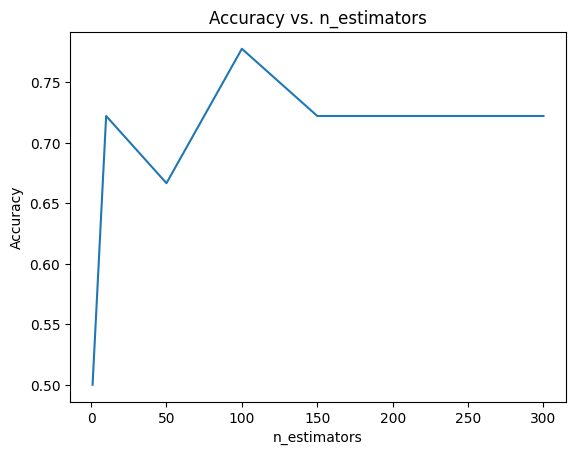

In [17]:
n_estimators_vals = [1, 10, 50, 100, 150, 200, 300]

score_best = 0
n_best = 0

scores = []

for n in n_estimators_vals:
    rf = RandomForestClassifier(random_state=123, n_estimators=n)
    rf.fit(X_train, y_train)
    s = rf.score(X_test, y_test)
    scores.append(s)
    if (s > score_best):
        score_best = s
        n_best = n
        
plt.plot(n_estimators_vals, scores)
plt.title("Accuracy vs. n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
        
print("Best accuracy was ", score_best, " with n_estimators value = ", n_best) 

After hyperparameter tuning, the best accuracy of 0.78 was obtained with n_estimators = 100. There was no improvement in accuracy compared to default values.

### k-Nearest Neighbors

In [18]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)                                                                                                                                                    
knn.score(X_test, y_test)

0.4444444444444444

Initial accuracy of kNN is 0.44.

Tuning Hyperparameter n_neighbours

Best accuracy was  0.7777777777777778  with n_neighbors value =  1


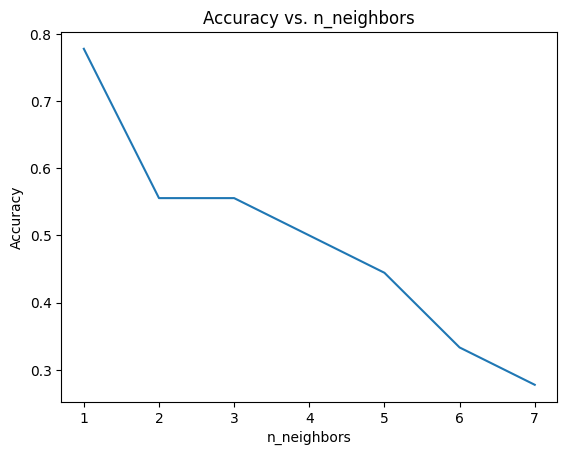

In [19]:
n_neighbors_vals = [1, 2, 3, 4, 5, 6, 7]

score_best = 0
n_best = 0

scores = []

for n in n_neighbors_vals:
    rf = KNeighborsClassifier(n_neighbors=n)
    rf.fit(X_train, y_train)
    s = rf.score(X_test, y_test)
    scores.append(s)
    if (s > score_best):
        score_best = s
        n_best = n
        
plt.plot(n_neighbors_vals, scores)
plt.title("Accuracy vs. n_neighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
        
print("Best accuracy was ", score_best, " with n_neighbors value = ", n_best) 

The best accuracy of 0.78 was obtained with n_neighbors of 1.

## Model Selection

we have decided to use logistic regression as our ML model as it has similar performance to the rest of the models considered while also having the ability to provide probabilities for each disease. This is a useful feature as it can provide multiple possible diagnoses at once in order of most probable to least probable.

For the final model, the logistic regression model is trained on the entire dataset. The C hyperparameter is set to 3.16.

In [20]:
lr_f = LogisticRegression(max_iter = 300, C = 3.16)

X = df.drop(columns=["disease", "source"])
y = df["disease"]

lr_f.fit(X, y)

LogisticRegression(C=3.16, max_iter=300)

Testing the final model on example from before with true class 'velvet':

(0.0, 1.0)

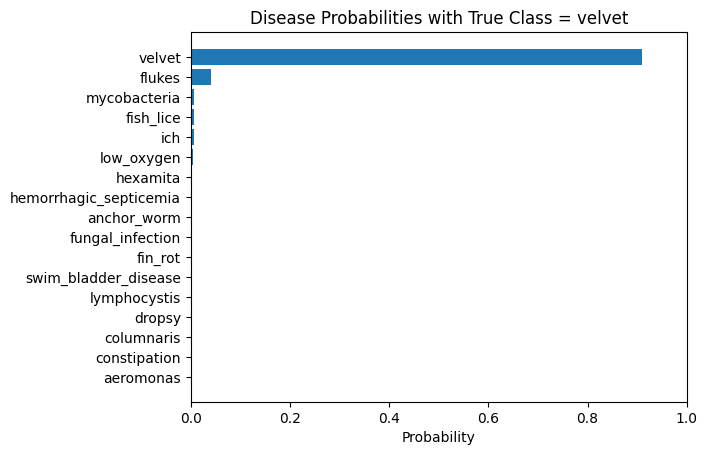

In [21]:
p_f = lr_f.predict_proba(ex)[0]

diseases_f = lr_f.classes_

df3 = pd.DataFrame([diseases_f,p_f]).T.sort_values(1,ascending=True)
    
plt.barh(df3[0], df3[1])
plt.title("Disease Probabilities with True Class = {0}".format(y_train.iloc[0]))
plt.xlabel("Probability")

plt.xlim([0, 1])

It appears the model trained on the entire dataset performs similarly as the one trained just on training data for this example (disease probabilities stayed the same compared to training phase).

Testing on a few more examples:

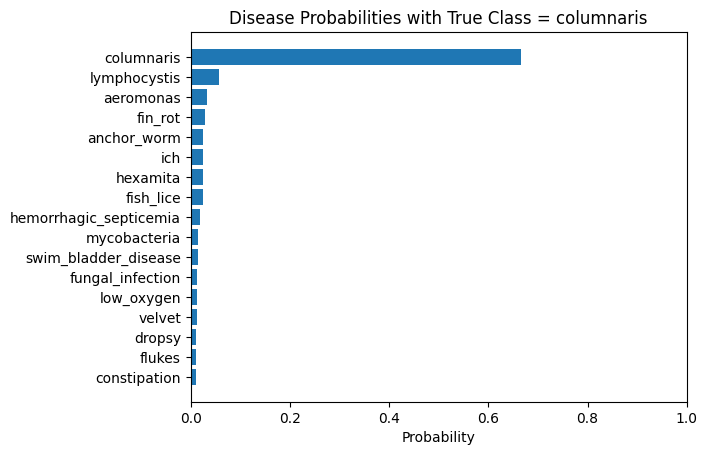

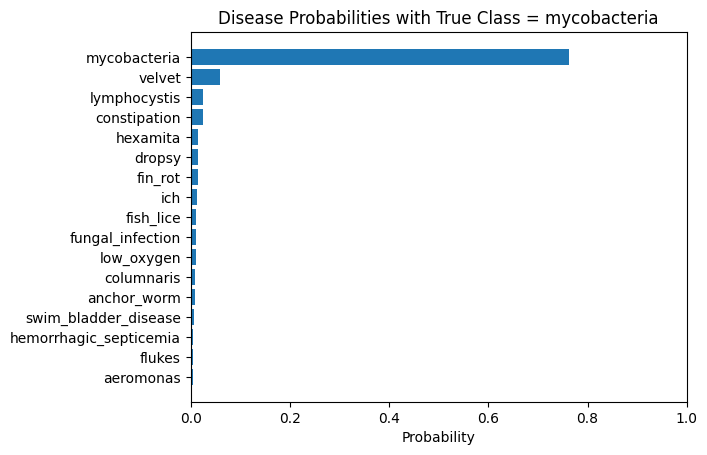

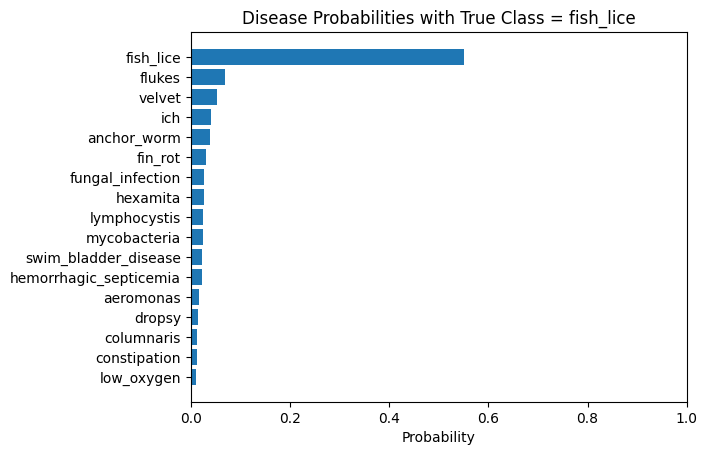

In [22]:
#exs = [X_train.iloc[[0]], X_train.iloc[[23]], X_train.iloc[[42]]]
idx = [2, 23, 42]

for i in idx:
    p = lr_f.predict_proba(X.iloc[[i]])[0]
    
    df = pd.DataFrame([lr_f.classes_,p]).T.sort_values(1,ascending=True)
    plt.barh(df[0], df[1])
    plt.title("Disease Probabilities with True Class = {0}".format(y.iloc[i]))
    plt.xlabel("Probability")

    plt.xlim([0, 1])
    plt.show()

In [23]:
X_train = train_df.drop(columns=["disease", "source"])
print(X_train.columns)

Index(['pits_on_head_lateral_line', 'stringy_feces', 'white_feces',
       'difficulty_swimming', 'erratic_swimming', 'bulging_eyes',
       'cloudy_eyes', 'weight_loss', 'deformed', 'discolored', 'lost_appetite',
       'lethargy', 'cant_stay_upright', 'near_surface', 'difficulty_breathing',
       'pale_gills', 'inflamed_gills', 'scratching', 'skin_inflamed',
       'skin_lesions', 'red_streaks_fin', 'cauliflower_growths', 'red_spots',
       'cottony_growths', 'mouth_lesions', 'white_spots', 'yellow_spots',
       'mucous_skin', 'velvety_skin', 'visible_parasite', 'protruding_scales',
       'bloated_abdomen', 'clamped_fins', 'ragged_fins'],
      dtype='object')


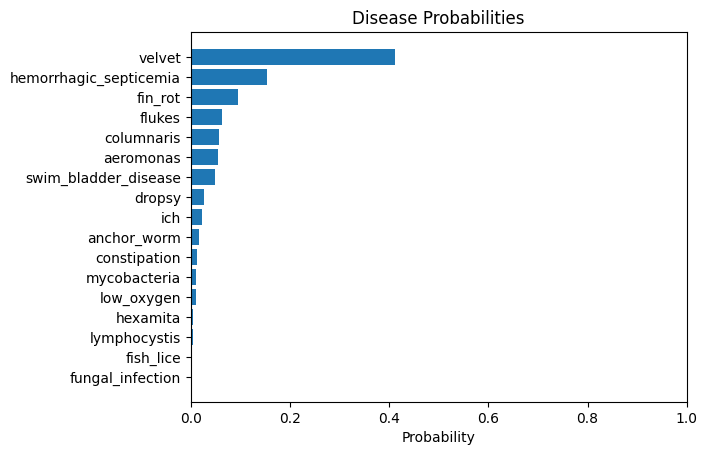

In [24]:
def predict_disease(model):
    # Create an empty DataFrame with the same columns as your training data
    user_input = pd.DataFrame(columns=X_train.columns)

    # Ask the user to input values for each symptom
    for symptom in X_train.columns:
        value = input(f"Enter value for {symptom}: ")
        user_input.loc[0, symptom] = value

    # Use the model to predict the disease probabilities
    probabilities = model.predict_proba(user_input)[0]

    # Create a DataFrame to display the probabilities
    df = pd.DataFrame([model.classes_, probabilities]).T.sort_values(1, ascending=True)

    # Plot the probabilities
    plt.barh(df[0], df[1])
    plt.title("Disease Probabilities")
    plt.xlabel("Probability")
    plt.xlim([0, 1])
    plt.show()

# Use the function with your trained model
predict_disease(lr_f)

In [32]:
import tkinter as tk
from tkinter import messagebox, scrolledtext
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Assuming lr_f is your trained model and X_train is your training data
def predict_disease():
    # Your prediction code 
    user_input = pd.DataFrame(columns=X_train.columns)

    # Get the values from the checkboxes
    for symptom, var in zip(X_train.columns, vars):
        user_input.loc[0, symptom] = var.get()

    # Use the model to predict the disease probabilities
    probabilities = lr_f.predict_proba(user_input)[0]

    # Create a DataFrame to display the probabilities
    df = pd.DataFrame([lr_f.classes_, probabilities]).T.sort_values(1, ascending=True)

    # Display the probabilities in the text box
    text.delete('1.0', tk.END)
    for disease, prob in zip(df[0], df[1]):
        text.insert(tk.END, f"{disease}: {prob}\n")

# Create a bar plot of the probabilities
    fig, ax = plt.subplots()
    ax.barh(df[0], df[1])  # Use barh() instead of bar() to create a horizontal bar plot
    ax.set_xlabel('Probability')
    ax.set_ylabel('Disease')

    # Display the plot in the Tkinter application
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().grid(row=len(X_train.columns)//3 + 3, column=0, columnspan=3)

root = tk.Tk()

# Create a checkbox for each symptom
vars = []
for i, symptom in enumerate(X_train.columns):
    var = tk.IntVar()
    vars.append(var)
    cb = tk.Checkbutton(root, text=symptom, variable=var)
    # Arrange the checkboxes in a grid with 3 columns
    cb.grid(row=i//3, column=i%3)

# Create a button to submit the form
button = tk.Button(root, text="Predict Disease", command=predict_disease)
button.grid(row=len(X_train.columns)//3 + 1, column=0, columnspan=3)

# Create a text box to display the probabilities
text = scrolledtext.ScrolledText(root)
text.grid(row=len(X_train.columns)//3 + 2, column=0, columnspan=3)

root.mainloop()